# Hypertension Prediction Project - Midterm Notebook

## 1. Introduction

In this notebook, we aim to predict the risk of hypertension for individuals based on various health parameters. Hypertension, also known as high blood pressure, is a condition that significantly increases the risk of heart disease, stroke, and other health problems. The goal of this study is to build a machine learning model that can effectively classify individuals as being at risk for hypertension. We will follow the standard process of data analysis, which includes data preparation, exploratory data analysis (EDA), feature engineering, model training, evaluation, and selection.

## 2. Data Preparation

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mutual_info_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from tqdm.auto import tqdm
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

data = './hypertension_dataset.csv'
df = pd.read_csv(data)
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,57.0,1.0,3,145,233,1,0,150,0,2.3,0,0,1,1
1,64.0,0.0,2,130,250,0,1,187,0,3.5,0,0,2,1
2,52.0,1.0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56.0,0.0,1,120,236,0,1,178,0,0.8,2,0,2,1
4,66.0,0.0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,51.0,1.0,0,140,192,0,1,148,0,0.4,1,0,1,1
6,42.0,0.0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,38.0,0.0,1,120,263,0,1,173,0,0.0,2,0,3,1
8,72.0,0.0,2,172,199,1,1,162,0,0.5,2,0,3,1
9,47.0,0.0,2,150,168,0,1,174,0,1.6,2,0,2,1


### Display Basic Information about the Dataset

In [3]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26083 entries, 0 to 26082
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       26083 non-null  float64
 1   sex       26058 non-null  float64
 2   cp        26083 non-null  int64  
 3   trestbps  26083 non-null  int64  
 4   chol      26083 non-null  int64  
 5   fbs       26083 non-null  int64  
 6   restecg   26083 non-null  int64  
 7   thalach   26083 non-null  int64  
 8   exang     26083 non-null  int64  
 9   oldpeak   26083 non-null  float64
 10  slope     26083 non-null  int64  
 11  ca        26083 non-null  int64  
 12  thal      26083 non-null  int64  
 13  target    26083 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 2.8 MB


In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,26083.000000,26058.00000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000
mean,55.661389,0.50000,0.958594,131.592992,246.246061,0.149753,0.526512,149.655024,0.326573,1.039512,1.400299,0.721849,2.318752,0.547253
std,15.189768,0.50001,1.023931,17.588809,51.643522,0.356836,0.525641,22.858109,0.468969,1.165138,0.616513,1.011608,0.604659,0.497772
min,11.000000,0.00000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,0.00000,0.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,0.50000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,67.000000,1.00000,2.000000,140.000000,275.000000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,98.000000,1.00000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Check for Missing Values

In [6]:
df.isnull().sum()

age          0
sex         25
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
target       0
dtype: int64

## Feature Analysis and Data Visualization

### Plot distributions for numerical columns and frequency

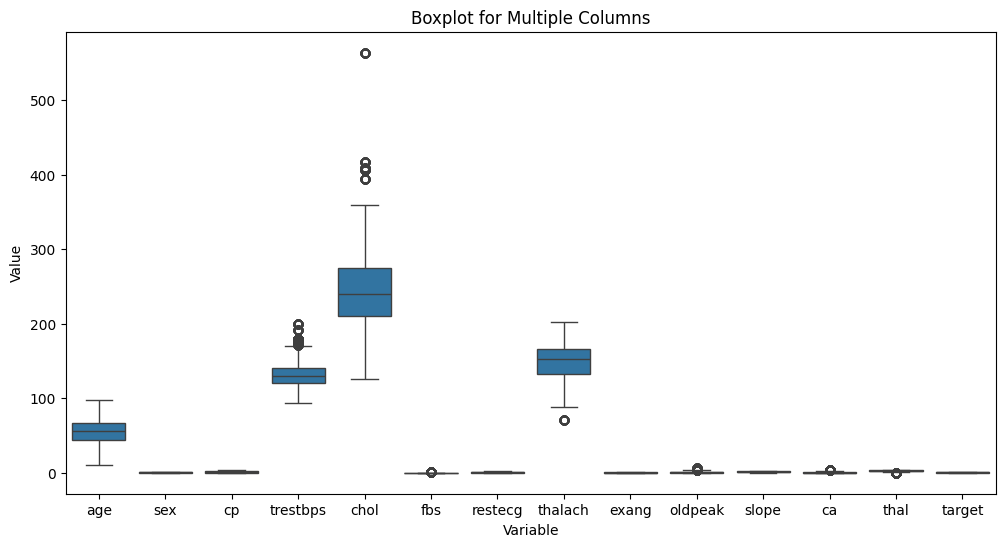

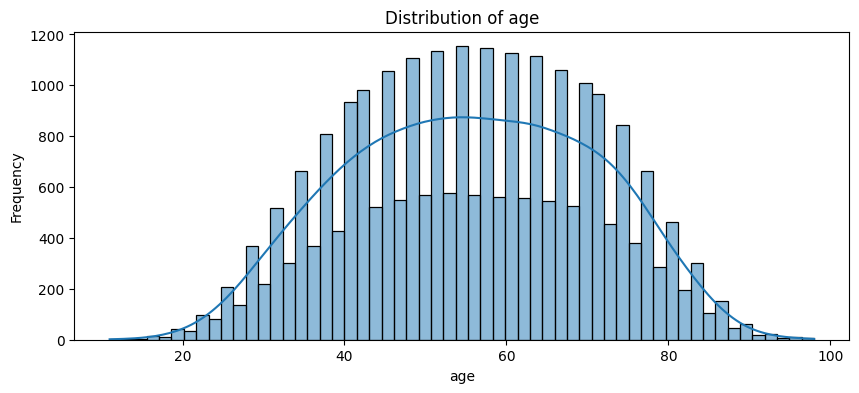

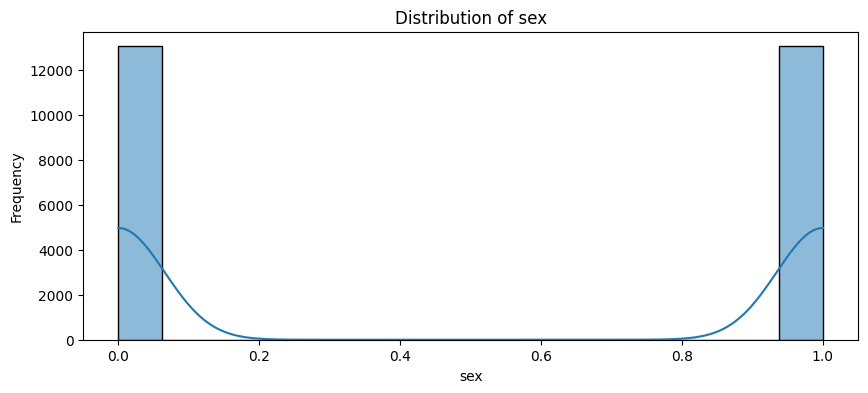

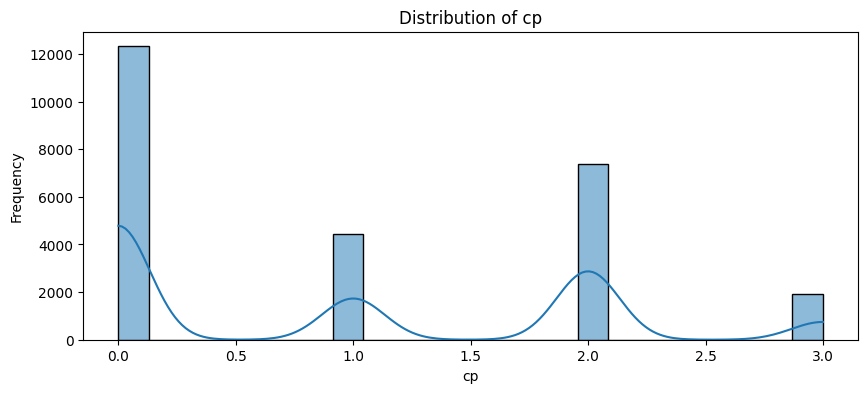

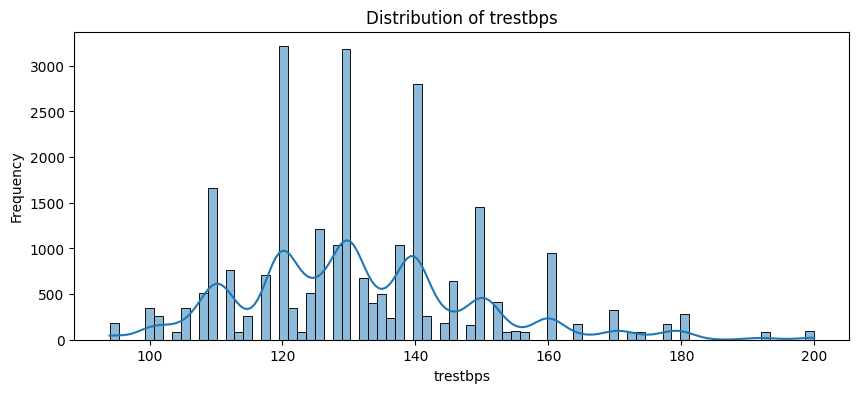

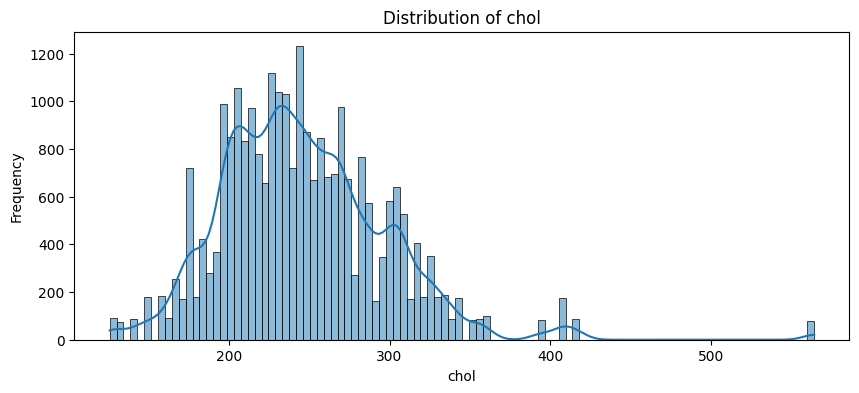

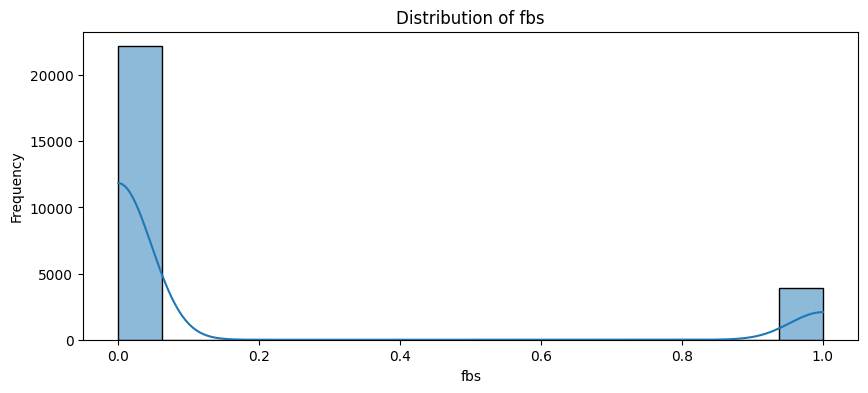

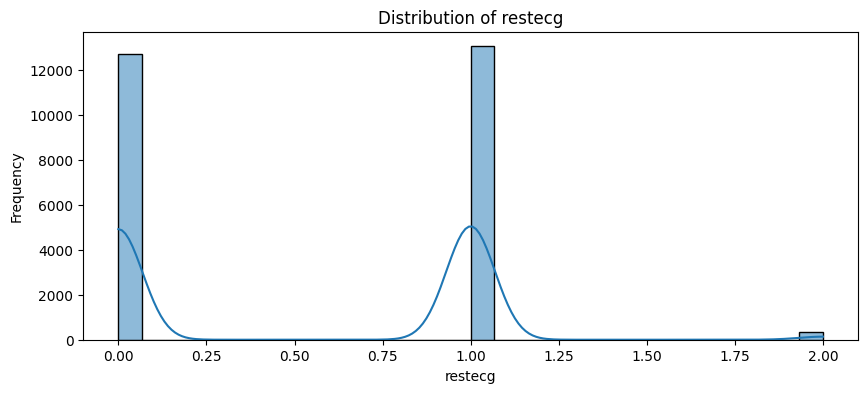

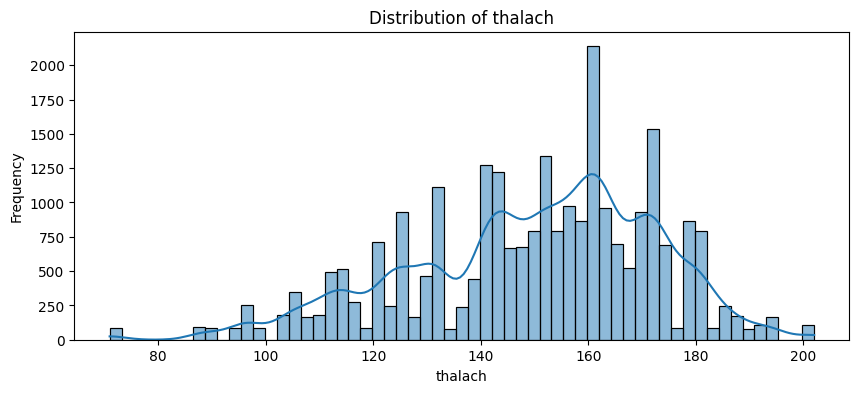

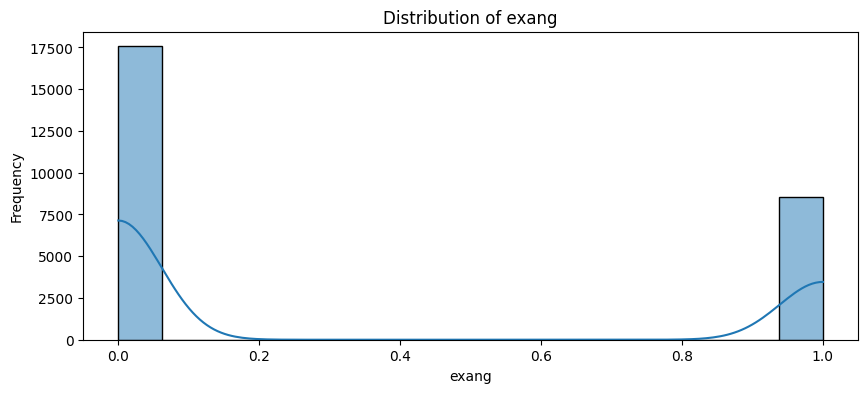

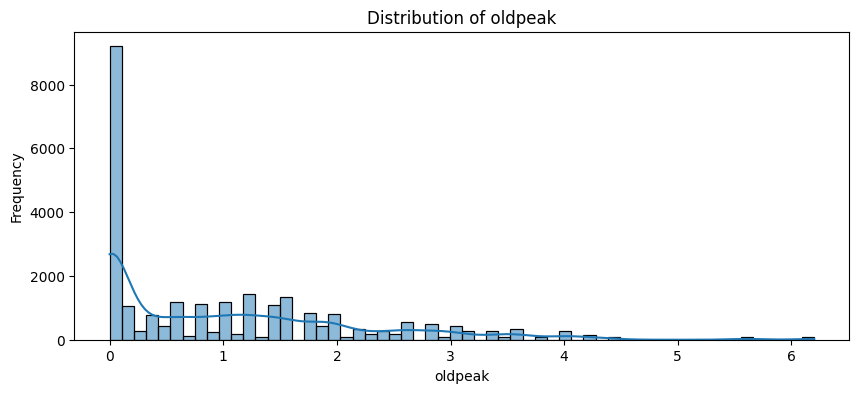

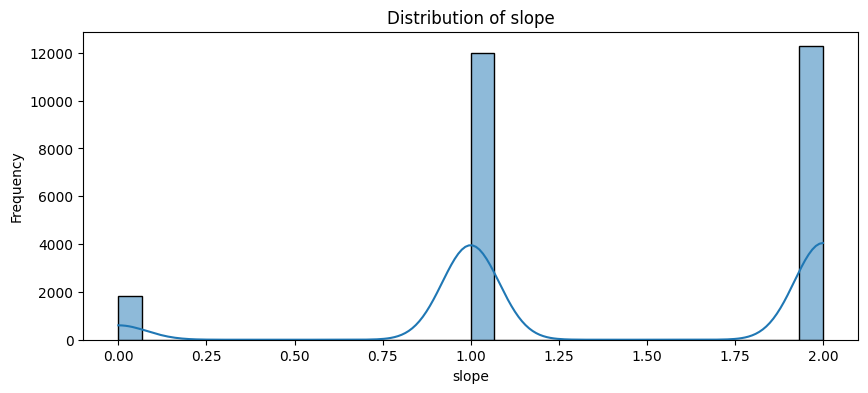

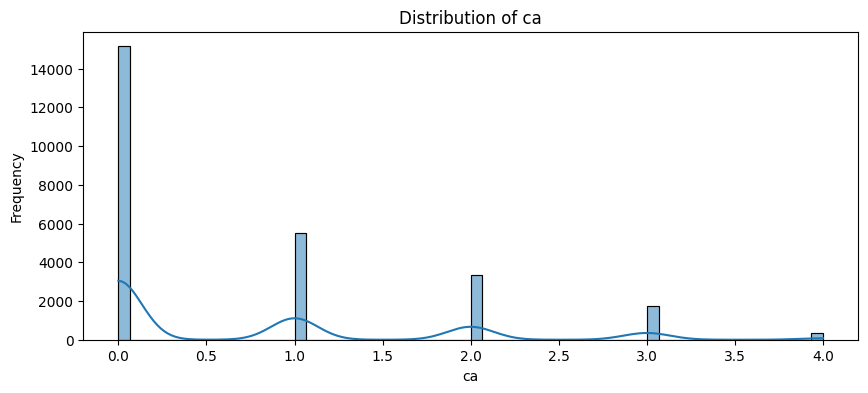

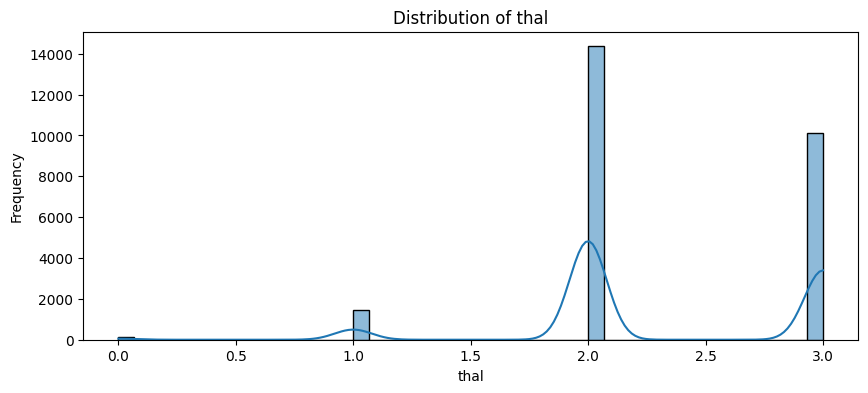

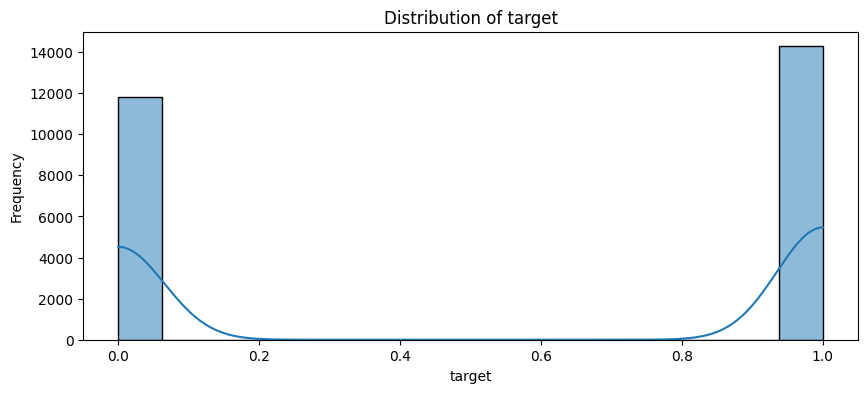

In [7]:
def show_boxplot(df):
    df_numerical = df.select_dtypes(include=['number'])
    df_melted = df_numerical.melt(var_name='Variable', value_name='Value')
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Variable', y='Value', data=df_melted)
    plt.title('Boxplot for Multiple Columns')
    plt.show()

show_boxplot(df)

for column in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

### Scatter Plots for Feature Relationships

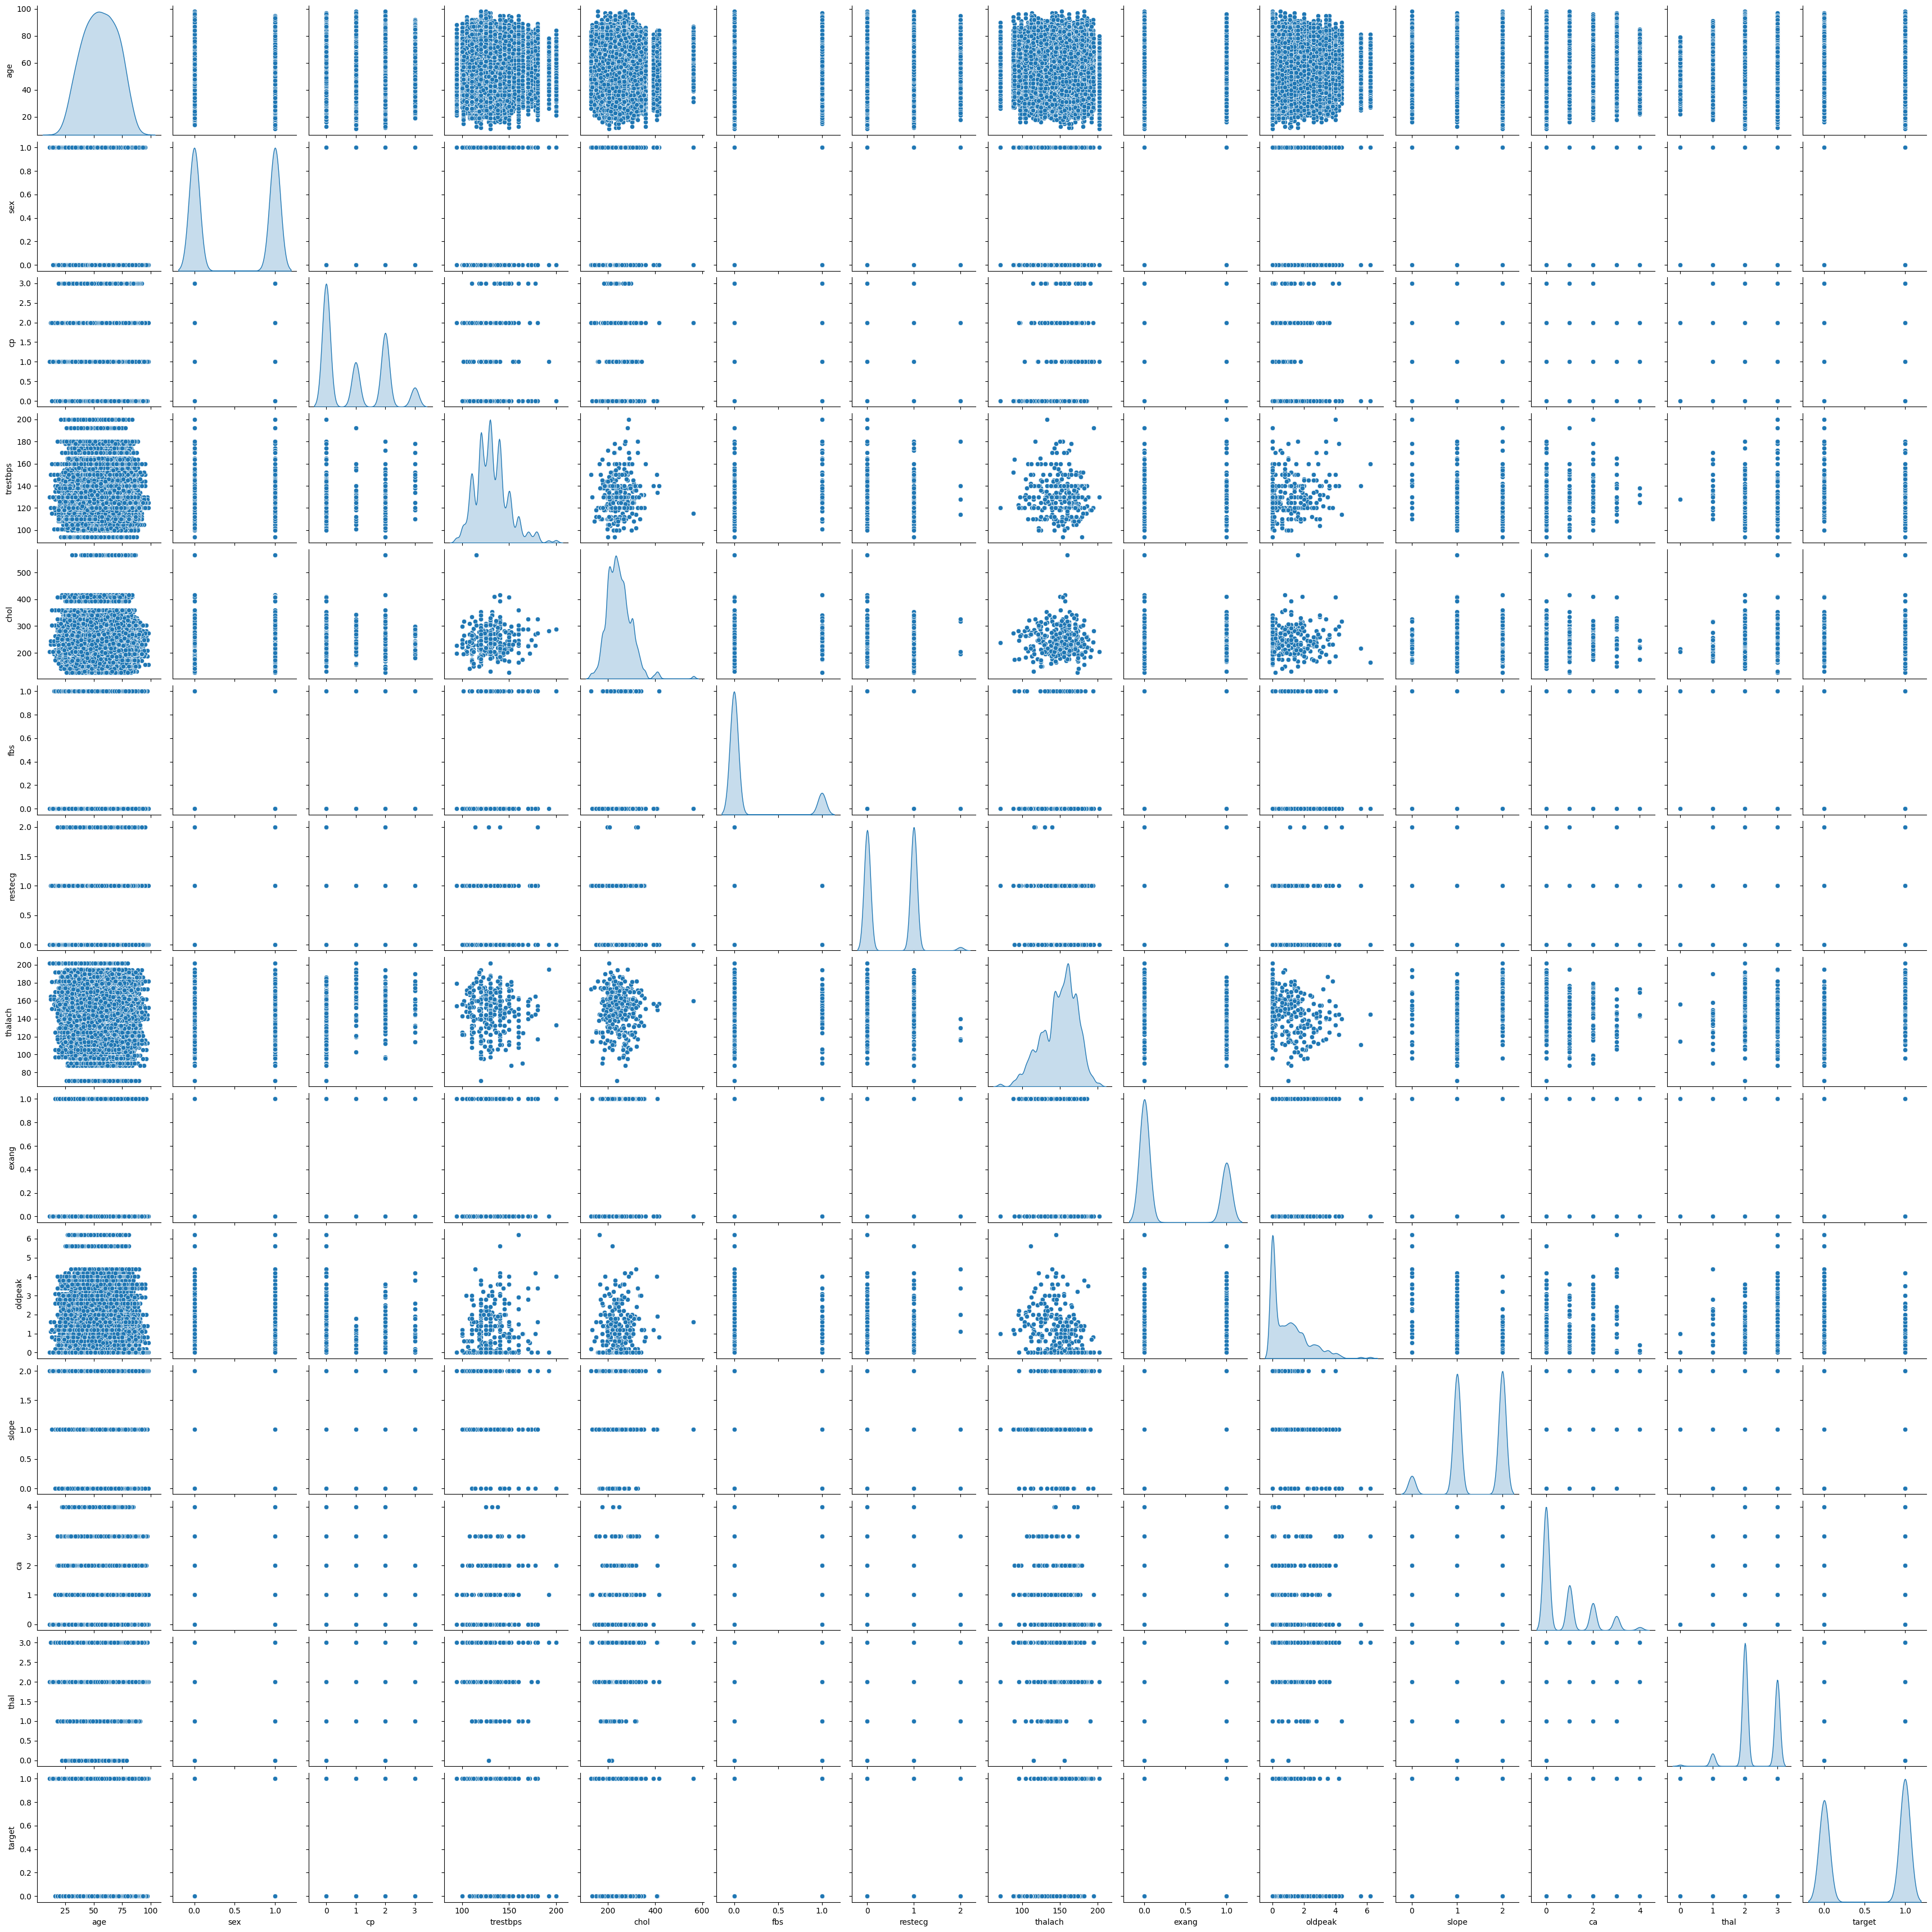

In [8]:
sns.pairplot(df, diag_kind='kde')
plt.show()

## 3. Data Cleaning and Feature Engineering

### Remove Outliers

In [11]:
columns_to_check = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

def remove_outliers_iqr(df, column):
    if column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        print(f"Outliers removed from column '{column}'")
    else:
        print(f"Column '{column}' not found in DataFrame.")
    return df

for column in columns_to_check:
    df = remove_outliers_iqr(df, column)

df.info()

Outliers removed from column 'age'
Outliers removed from column 'trestbps'
Outliers removed from column 'chol'
Outliers removed from column 'thalach'
Outliers removed from column 'oldpeak'
<class 'pandas.core.frame.DataFrame'>
Index: 24447 entries, 0 to 26082
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       24447 non-null  float64
 1   sex       24422 non-null  float64
 2   cp        24447 non-null  int64  
 3   trestbps  24447 non-null  int64  
 4   chol      24447 non-null  int64  
 5   fbs       24447 non-null  int64  
 6   restecg   24447 non-null  int64  
 7   thalach   24447 non-null  int64  
 8   exang     24447 non-null  int64  
 9   oldpeak   24447 non-null  float64
 10  slope     24447 non-null  int64  
 11  ca        24447 non-null  int64  
 12  thal      24447 non-null  int64  
 13  target    24447 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 2.8 MB


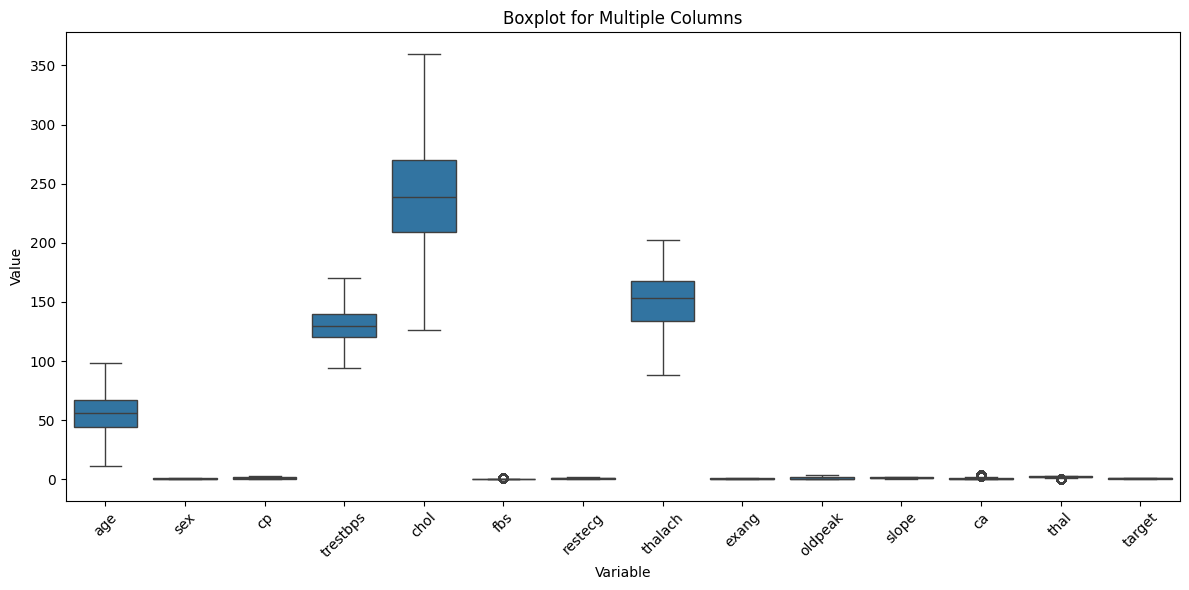

In [12]:
def show_boxplot(df):
    df_numerical = df.select_dtypes(include=['number'])
    
    df_melted = df_numerical.melt(var_name='Variable', value_name='Value')
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Variable', y='Value', data=df_melted)
    plt.title('Boxplot for Multiple Columns')
    plt.xticks(rotation=45) 
    plt.tight_layout() 
    plt.show()

show_boxplot(df)

### Feature Analysis and Data Visualization

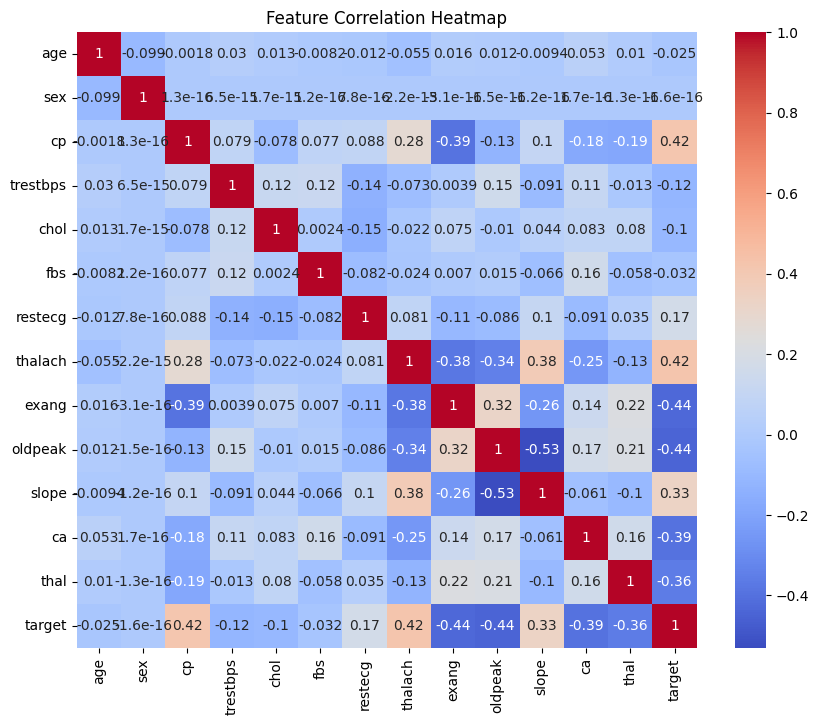

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## 4. Feature Engineering

### Creating Categorical Features

In [14]:
df['Age_Category'] = pd.cut(df['age'], bins=[0, 18, 35, 50, 65, np.inf],
                            labels=['Child', 'Young Adult', 'Adult', 'Middle Age', 'Senior'])

df = pd.get_dummies(df, columns=['Age_Category'], drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24447 entries, 0 to 26082
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       24447 non-null  float64
 1   sex                       24422 non-null  float64
 2   cp                        24447 non-null  int64  
 3   trestbps                  24447 non-null  int64  
 4   chol                      24447 non-null  int64  
 5   fbs                       24447 non-null  int64  
 6   restecg                   24447 non-null  int64  
 7   thalach                   24447 non-null  int64  
 8   exang                     24447 non-null  int64  
 9   oldpeak                   24447 non-null  float64
 10  slope                     24447 non-null  int64  
 11  ca                        24447 non-null  int64  
 12  thal                      24447 non-null  int64  
 13  target                    24447 non-null  int64  
 14  Age_Categor

### Update Feature Lists

In [15]:
categorical = [col for col in df.columns if 'Age_Category' in col]
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

print("Categorical variables:", categorical)
print("Numerical variables:", numerical)

Categorical variables: ['Age_Category_Young Adult', 'Age_Category_Adult', 'Age_Category_Middle Age', 'Age_Category_Senior']
Numerical variables: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


### Split Dataset

In [16]:
def generate_data(df, categorical, numerical, target_label='target'):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

    df_train = df_full_train[categorical + numerical]
    df_val = df_test[categorical + numerical]
    
    y_train = df_full_train[target_label].values
    y_val = df_test[target_label].values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)
    val_dicts = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dicts)

    return df_train, df_val, y_train, y_val, dv, X_train, X_val

df_train, df_val, y_train, y_val, dv, X_train, X_val = generate_data(df, categorical, numerical)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (19557, 9), y_train shape: (19557,)
X_val shape: (4890, 9), y_val shape: (4890,)


## 5. Model Training and Evaluation

### Model Training and Hyperparameter Tuning

In [22]:
def evaluation_model(title, model, param_grid, X_train, y_train, X_val, y_val, cv=5, scoring='f1'):
    try:
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            verbose=1,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_

        print(f"{title} - Best Hyperparameters: {best_params}")

        y_pred = best_model.predict(X_val)
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]

        print(f"{title} Classification Report:\n", classification_report(y_val, y_pred, zero_division=1))
        print("AUC-ROC Score:", roc_auc_score(y_val, y_pred_proba))
        
        return best_params, best_model

    except Exception as e:
        print(f"An error occurred while evaluating the model: {str(e)}")

model_lr = LogisticRegression(solver='liblinear', random_state=42)

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None]
}

best_params_lr, best_model_lr = evaluation_model(
    "LogisticRegression", model_lr, param_grid_lr, X_train, y_train, X_val, y_val
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
LogisticRegression - Best Hyperparameters: {'C': 100, 'class_weight': None, 'penalty': 'l2'}
LogisticRegression Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.70      2153
           1       0.75      0.83      0.79      2737

    accuracy                           0.75      4890
   macro avg       0.75      0.74      0.74      4890
weighted avg       0.75      0.75      0.75      4890

AUC-ROC Score: 0.8032307775591103


### Random Forest and Decision Tree Classifiers

In [24]:
from sklearn.model_selection import RandomizedSearchCV

model_rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [10, 15],
    'max_depth': [3, 5],
    'min_samples_split': [15, 20],
    'min_samples_leaf': [10, 15],
    'class_weight': ['balanced']
}

random_search_rf = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_grid_rf,
    n_iter=4,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

random_search_rf.fit(X_train, y_train)

best_params_rf = random_search_rf.best_params_
best_model_rf = random_search_rf.best_estimator_

y_pred = best_model_rf.predict(X_val)
y_pred_proba = best_model_rf.predict_proba(X_val)[:, 1]

print(f"RandomForest - Best Hyperparameters: {best_params_rf}")
print("RandomForest Classification Report:\n", classification_report(y_val, y_pred, zero_division=1))
print("AUC-ROC Score:", roc_auc_score(y_val, y_pred_proba))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
RandomForest - Best Hyperparameters: {'n_estimators': 10, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_depth': 5, 'class_weight': 'balanced'}
RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.73      0.80      2153
           1       0.81      0.92      0.86      2737

    accuracy                           0.84      4890
   macro avg       0.85      0.82      0.83      4890
weighted avg       0.84      0.84      0.83      4890

AUC-ROC Score: 0.9237156402575973


## 6. Model Selection and Final Evaluation

In [25]:
def classification_evaluation_report(y_test, y_pred_proba, title, best_params, t=0.5):
    y_pred = (y_pred_proba >= t).astype(int)
    
    print(f"{title} Classification Report: {best_params}")
    print(classification_report(y_test, y_pred, zero_division=1))

    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC-ROC Score: {auc_roc}")

classification_evaluation_report(
    y_val, 
    best_model_lr.predict_proba(X_val)[:, 1], 
    "LogisticRegression", 
    best_params_lr, 
    t=0.5
)

LogisticRegression Classification Report: {'C': 100, 'class_weight': None, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      2153
           1       0.75      0.83      0.79      2737

    accuracy                           0.75      4890
   macro avg       0.75      0.74      0.74      4890
weighted avg       0.75      0.75      0.75      4890

Precision: 0.7499174099768748
Recall: 0.8293752283522104
F1 Score: 0.78764746703678
AUC-ROC Score: 0.8032307775591103


## 7. Save and Load the Model

In [26]:
def save_model(dv, model, output_file):
    with open(output_file, 'wb') as f_out:
        pickle.dump((dv, model), f_out)
    return output_file

input_file = save_model(dv, best_model_lr, 'lr_model_hypertension.bin')

In [27]:
def evaluate_thresholds(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 21)
    metrics = []

    for t in thresholds:
        y_pred = y_pred_proba >= t
        precision = precision_score(y_true, y_pred, zero_division=1)
        recall = recall_score(y_true, y_pred, zero_division=1)
        f1 = f1_score(y_true, y_pred, zero_division=1)
        auc_roc = roc_auc_score(y_true, y_pred_proba)
        
        metrics.append((t, precision, recall, f1, auc_roc))
        
        print(f"Threshold: {t:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f} | AUC-ROC: {auc_roc:.2f}")

    return metrics

y_pred_proba_lr = best_model_lr.predict_proba(X_val)[:, 1]
metrics_lr = evaluate_thresholds(y_val, y_pred_proba_lr)

Threshold: 0.00 | Precision: 0.56 | Recall: 1.00 | F1: 0.72 | AUC-ROC: 0.80
Threshold: 0.05 | Precision: 0.56 | Recall: 1.00 | F1: 0.72 | AUC-ROC: 0.80
Threshold: 0.10 | Precision: 0.58 | Recall: 0.99 | F1: 0.73 | AUC-ROC: 0.80
Threshold: 0.15 | Precision: 0.62 | Recall: 0.99 | F1: 0.76 | AUC-ROC: 0.80
Threshold: 0.20 | Precision: 0.65 | Recall: 0.99 | F1: 0.78 | AUC-ROC: 0.80
Threshold: 0.25 | Precision: 0.66 | Recall: 0.98 | F1: 0.79 | AUC-ROC: 0.80
Threshold: 0.30 | Precision: 0.69 | Recall: 0.96 | F1: 0.81 | AUC-ROC: 0.80
Threshold: 0.35 | Precision: 0.70 | Recall: 0.93 | F1: 0.80 | AUC-ROC: 0.80
Threshold: 0.40 | Precision: 0.71 | Recall: 0.90 | F1: 0.79 | AUC-ROC: 0.80
Threshold: 0.45 | Precision: 0.72 | Recall: 0.84 | F1: 0.78 | AUC-ROC: 0.80
Threshold: 0.50 | Precision: 0.75 | Recall: 0.83 | F1: 0.79 | AUC-ROC: 0.80
Threshold: 0.55 | Precision: 0.75 | Recall: 0.80 | F1: 0.77 | AUC-ROC: 0.80
Threshold: 0.60 | Precision: 0.75 | Recall: 0.71 | F1: 0.73 | AUC-ROC: 0.80
Threshold: 0

In [28]:
from sklearn.model_selection import cross_val_score, KFold

def cross_validation_report(model, X, y, cv_splits=5, scoring='roc_auc'):
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring=scoring)
    
    print(f"Cross-Validation Scores: {scores}")
    print(f"Mean AUC-ROC Score: {scores.mean()}")
    print(f"Standard Deviation of Scores: {scores.std()}")

print("Logistic Regression Cross Validation")
cross_validation_report(best_model_lr, X_train, y_train, cv_splits=5, scoring='roc_auc')

print("\nRandom Forest Cross Validation")
cross_validation_report(best_model_rf, X_train, y_train, cv_splits=5, scoring='roc_auc')

Logistic Regression Cross Validation
Cross-Validation Scores: [0.79717667 0.81117691 0.79156846 0.81448651 0.79881042]
Mean AUC-ROC Score: 0.8026437931544022
Standard Deviation of Scores: 0.008721366084416296

Random Forest Cross Validation
Cross-Validation Scores: [0.93481048 0.92826041 0.91498534 0.93614897 0.9197911 ]
Mean AUC-ROC Score: 0.9267992579610069
Standard Deviation of Scores: 0.008275443582368092


## 8. Model Deployment

In [ ]:
from flask import Flask, request, jsonify

app = Flask(__name__)

dv, model = pickle.load(open('lr_model_hypertension.bin', 'rb'))

@app.route('/predict', methods=['POST'])
def predict():
    patient = request.get_json()
    X = dv.transform([patient])
    y_pred = model.predict_proba(X)[0, 1]
    return jsonify({'hypertension_risk': y_pred})

if __name__ == "__main__":
    app.run(debug=True, host='0.0.0.0', port=9696)